In [ ]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.translators.ising import tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

from docplex.mp.model import Model
from qiskit.aqua.translators.ising import docplex
from qiskit.aqua.operators import TPBGroupedWeightedPauliOperator
from qiskit.aqua.operators.op_converter import to_tpb_grouped_weighted_pauli_operator

In [32]:
# Define our variables

n = 4 # facility locations
m = 4 # demand nodes
r = 10 # radius of coverage
p = 2 # number of routers
a = [4, 3, 2, 0] # population at a node

distance
 [[ 0. 29. 18. 11.]
 [29.  0. 46. 22.]
 [18. 46.  0. 28.]
 [11. 22. 28.  0.]]


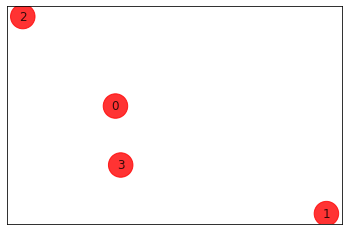

In [34]:
seed = 10598

ins = tsp.random_tsp(n)
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
colors = ['r' for node in G.nodes()]
pos = {k: v for k, v in enumerate(ins.coord)}
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
print('distance\n', ins.w)

In [35]:
# get our distance matrix were columns 
dm = ins.w[0:m]
dm

array([[ 0., 29., 18., 11.],
       [29.,  0., 46., 22.],
       [18., 46.,  0., 28.],
       [11., 22., 28.,  0.]])

In [120]:
N = []
r = 20
for j in range(m):
    N_m = []
    [N_m.append(i) for i,v in enumerate(dm[j]) if v <= r]
    N.append(N_m)
N

[[0, 2, 3], [1], [0, 2], [0, 3]]

p gives an upper bound (i.e. we need a maximum of two binary slack variables for each constraint) but the size of N can decrease the required number of slack variables (i.e. if there is only one element in a N_i, then we only need one slack variable)

In [122]:
# Create an instance of a model and variables

mdl = Model(name='max_vars')
x = {i: mdl.binary_var(name='x_{0}'.format(i)) for i in range(n)} # facility located at i
y = {i: mdl.binary_var(name='y_{0}'.format(i)) for i in range(m)} # i is covered by a facility
s0 = {i: mdl.binary_var(name='s0_{0}'.format(i)) for i in range(m)} # slack variable
s1 = {i: mdl.binary_var(name='s1_{0}'.format(i)) for i in range(m)} # slack variable

# Objective function
max_vars_func = mdl.sum(a[i]*y[i] for i in range(m))
mdl.maximize(max_vars_func)

# Constraints
for j in range(m):
    mdl.add_constraint(mdl.sum(x[i] for i in N[j]) - s0[j] - s1[j] - y[j] == 0)

# Constraint
mdl.add_constraint(mdl.sum(x[i] for i in range(0,n)) == p)

docplex.mp.LinearConstraint[](x_0+x_1+x_2+x_3,EQ,2)

In [123]:
print(mdl.export_to_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: max_vars

Maximize
 obj: 4 y_0 + 3 y_1 + 2 y_2
Subject To
 c1: x_0 + x_2 + x_3 - y_0 - s0_0 - s1_0 = 0
 c2: x_1 - y_1 - s0_1 - s1_1 = 0
 c3: x_0 + x_2 - y_2 - s0_2 - s1_2 = 0
 c4: x_0 + x_3 - y_3 - s0_3 - s1_3 = 0
 c5: x_0 + x_1 + x_2 + x_3 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= y_0 <= 1
 0 <= y_1 <= 1
 0 <= y_2 <= 1
 0 <= y_3 <= 1
 0 <= s0_0 <= 1
 0 <= s0_1 <= 1
 0 <= s0_2 <= 1
 0 <= s0_3 <= 1
 0 <= s1_0 <= 1
 0 <= s1_1 <= 1
 0 <= s1_2 <= 1
 0 <= s1_3 <= 1

Binaries
 x_0 x_1 x_2 x_3 y_0 y_1 y_2 y_3 s0_0 s0_1 s0_2 s0_3 s1_0 s1_1 s1_2 s1_3
End



In [124]:
qubitOp, offset = docplex.get_qubitops(mdl)

In [125]:
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

In [126]:
result

{'eigvals': array([-79.5+0.j]),
 'eigvecs': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'energy': -79.5,
 'wavefunction': array([[0., 0., 0., ..., 0., 0., 0.]]),
 'energies': array([-79.5])}

In [127]:
print('objective:', result['energy'] + offset) # offset is the constant part that cannot be optimised 

objective: -9.0


In [128]:
sol = docplex.sample_most_likely(result['eigvecs'][0])

x = sol[:n]
y = sol[n:n+m]
s_0 = sol[n+m:n+2*m]
s_1 = sol[n+2*m:]
print('sol:', sol)
print('x:', x)
print('y:', y)
print('slack:', s_0)
print('slack:', s_1)
cov = sum(a[i] * y[i] for i in range(m))
print('coverage', cov)

sol: [1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
x: [1. 1. 0. 0.]
y: [1. 1. 1. 0.]
slack: [0. 0. 0. 0.]
slack: [0. 0. 0. 1.]
coverage 9.0


In [ ]:
# Quantum Time
tpb_op = to_tpb_grouped_weighted_pauli_operator(qubitOp, TPBGroupedWeightedPauliOperator.sorted_grouping)
print(tpb_op.num_groups, tpb_op.num_qubits)
cobyla = COBYLA(maxiter=20)
ry = RY(tpb_op.num_qubits, depth=2, entanglement='linear')
vqe = VQE(tpb_op, ry, cobyla)
backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=10598, seed_transpiler=10598)

In [ ]:
result = vqe.run(quantum_instance)

sol = docplex.sample_most_likely(result['eigvecs'][0])

x = sol[:n]
y = sol[n:n+m]
print('energy:', result['energy'])
print('solution objective:', result['energy'] + offset)
print('x:', x)
print('y:', y)
cov = sum(a[i] * y[i] for i in range(m))
print('coverage', cov)

In [96]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.11.0',
 'qiskit-aer': '0.3.4',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.4.4',
 'qiskit-aqua': '0.6.1',
 'qiskit': '0.14.0'}